In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import json
import os
from copy import deepcopy
from tqdm import tqdm
from neuron import h

from cell_inference.config import paths, params
from cell_inference.cells.simulation import SIMULATION_CLASS
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.utils.random_parameter_generator import generate_parameters_from_config
from cell_inference.utils.feature_extractors.SummaryStats2D import process_lfp
from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap

DATA_PATH = paths.SIMULATED_DATA_PATH

## Load prediction and choose cell

In [2]:
## In vivo data
invivo_name = 'all_cell_LFP2D_Analysis_SensorimotorSpikeWaveforms_NP_SUTempFilter_NPExample_v2'
# invivo_name = 'all_cell_LFP2D_Analysis_SensorimotorSpikes_NPUnits_large.h5'

## Simulation data
TRIAL_NAME_PRED = 'Reduced_Order_stochastic_spkwid_trunkLR4_LactvCa_Loc3_h1_sumstats7' # select trial

## Trained model
model_name = 'CNN' # select model
# model_name = 'FCN'
# model_name = 'RF'

# stats_set_name = ''
# stats_set_name = 'GridStats'
stats_set_name = 'FullStats5'

isCNN = 'CNN' in model_name
if not isCNN and stats_set_name:
    model_name += '_' + stats_set_name

In [3]:
TRIAL_PRED_PATH = os.path.join(DATA_PATH, TRIAL_NAME_PRED)

INVIVO_PATH = os.path.join(paths.INVIVO_DATA_PATH, invivo_name)
INVIVO_DATA_PATH = os.path.join(INVIVO_PATH, invivo_name + '.h5')
INVIVO_LFP_PATH = os.path.join(INVIVO_PATH, 'lfp_' + invivo_name + '.npz')  # LFP and labels

with h5py.File(INVIVO_DATA_PATH,'r') as hf, np.load(INVIVO_LFP_PATH) as INVIVO_LFP:
    IDs = hf['ID'][()][INVIVO_LFP['good_indices']]

MODEL_PATH = os.path.join(TRIAL_PRED_PATH, model_name)
INVIVO_PRED_PATH = os.path.join(MODEL_PATH, invivo_name)
PRED_PATH = os.path.join(INVIVO_PRED_PATH, model_name + '_prediction.csv')
CORR_PATH = os.path.join(INVIVO_PRED_PATH, model_name + '_correlation.csv')

df_pred = pd.read_csv(PRED_PATH, index_col=0)
pred_idx = df_pred.index.get_indexer(IDs)
df_pred = df_pred.iloc[pred_idx]

corr_type = 'Coss'  # 'Log_Coss'
df_corr = pd.read_csv(CORR_PATH, index_col='cell id').loc[IDs]
df_corr = df_corr.sort_values(by=corr_type)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(pd.concat((df_corr, df_pred), axis=1))

### Choose cell

In [4]:
select_ID = 236 # 531

In [5]:
CONFIG_PRED_PATH = os.path.join(TRIAL_PRED_PATH, 'config.json')  # trial configuration
with open(CONFIG_PRED_PATH, 'r') as f:
    config_pred_dict = json.load(f)

inference_pred_list = config_pred_dict['Trial_Parameters']['inference_list']
print(inference_pred_list)

['y', 'd', 'theta', 'l_t', 'lr_pt', 'r_t', 'rr_dt']


## Setup

In [6]:
TRIAL_NAME = 'Reduced_Order_stochastic_spkwid_trunkLR4_LactvCa_Loc3_h1_Bio2'
TRIAL_PATH = os.path.join(DATA_PATH, TRIAL_NAME)

In [7]:
batch_id = 0
number_cells = 5  # number of neurons
number_locs = 1  # number of locations for each neuron
rand_seed = 0  # random seed
CONFIG_PATH = None  # load from config file if specified

if not 'get_ipython' in globals():
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('batch_id', type=int, nargs='?', default=None, help="Batch ID", metavar='Batch ID')
    parser.add_argument('-c', type=int, nargs='?', default=number_cells, help="Number of cells", metavar='# Cells')
    parser.add_argument('-l', type=int, nargs='?', default=number_locs, help="Number of locations", metavar='# Locations')
    parser.add_argument('-seed', type=int, nargs='?', default=rand_seed, help="Random Seed", metavar='Random Seed')
    parser.add_argument('-config', type=str, nargs='?', default=CONFIG_PATH, help="Configuration file path", metavar='Config File')
    args = parser.parse_args()
    batch_id = args.batch_id
    number_cells = args.c
    number_locs = args.l
    rand_seed = args.seed
    CONFIG_PATH = args.config
else:
    get_ipython().run_line_magic('matplotlib', 'inline')

In [8]:
if batch_id is None:
    batch_id = 0
    batch_suf = ''
else:
    batch_suf = '_%d' % batch_id

In [9]:
# load from config file if specified
use_config = CONFIG_PATH is not None
if use_config:
    if not os.path.isfile(CONFIG_PATH):
        CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')
    with open(CONFIG_PATH, 'r') as f:
        config_dict = json.load(f)
else:
    config_dict = deepcopy(config_pred_dict)

tr_p = config_dict['Trial_Parameters']
sim_p = config_dict['Simulation_Parameters']

if not use_config or 'Prediction_Parameters' not in config_dict:
    pred_p = dict(
        cell_id = select_ID,
        predictions = df_pred.loc[select_ID, inference_pred_list].to_dict(),
        correlation = df_corr.loc[select_ID].drop('layer').to_dict()
    )

    MAG_SCALE_PATH = os.path.join(TRIAL_PRED_PATH, 'magnitude_scale.json')
    with open(MAG_SCALE_PATH, 'r') as f:
        pred_p.update(json.load(f))

    config_dict['Prediction_Parameters'] = pred_p
else:
    pred_p = config_dict['Prediction_Parameters']

#### Trial configurations

In [10]:
CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')  # trial configuration
LFP_PATH = os.path.join(TRIAL_PATH, 'lfp' + batch_suf)  # LFP and labels
STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats' + batch_suf)  # summary statistics
NSPK_PATH = os.path.join(TRIAL_PATH, 'nspk' + batch_suf)  # summary statistics
MEM_VOLT_PATH = os.path.join(TRIAL_PATH, 'mem_volt' + batch_suf)  # membrane voltage and spike times

In [11]:
if use_config:
    number_cells = tr_p.get('number_cells', number_cells)
    number_locs = tr_p.get('number_locs', number_locs)
    number_samples = tr_p.get('number_samples', number_cells * number_locs)
    rand_seed = tr_p.get('rand_seed', rand_seed)
    inference_list = tr_p['inference_list']
    randomized_list = tr_p['randomized_list']
else:
    number_samples = number_cells * number_locs  # number of samples
    inference_list = ['s_nat', 's_kv3.1']  # + ['a_nat', 'a_kv3.1', 'a_m']
    randomized_list = ['alpha']  # randomized parameters not to inferred
    randomized_list = list(set(config_dict['Trial_Parameters']['randomized_list'])\
        - set(config_dict['Trial_Parameters']['inference_list']) | set(randomized_list))
    randomized_list += inference_list  # inference list comes after randomized
    # parameters not in the two lists above are fixed at default.
tr_p.update({
    'number_cells': number_cells, 'number_locs': number_locs, 
    'number_samples': number_samples, 'rand_seed': rand_seed, 'batch_id': batch_id,
    'inference_list': inference_list, 'randomized_list': randomized_list
})

#### Synapse parameters

In [12]:
simulation_class = sim_p.get('simulation_class', 'Simulation_stochastic') # 'Simulation_stochastic' or 'Simulation'
tstop = sim_p.get('tstop', getattr(params, 'TSTOP' if simulation_class == 'Simulation' else 'STOCHASTIC_TSTOP'))
syn_params = sim_p['syn_params']

#### Biophysical parameters

In [13]:
# Biophysical parameters
filepath = './cell_inference/resources/biophys_parameters/ReducedOrderL5_stochastic.json' # active dendrites
# filepath = './cell_inference/resources/biophys_parameters/ReducedOrderL5.json' # higer gNa dendrites

# Common parameters
biophys_param = [np.nan, 0.0213 * 0.6, 0.0213 * 0.6, 0.693 * 2, 0.000261 * 2,
                   np.nan, np.nan, np.nan, np.nan, np.nan,
                   np.nan, np.nan, np.nan, np.nan, .6, 2.4]
biophys_comm = {}

# Whether use parameter interpreter
interpret_params = True
interpret_type = 3

# Read from config
filepath = sim_p.get('full_biophys', filepath)
biophys_default = sim_p.get('biophys_param', biophys_param)
biophys_comm = sim_p.get('biophys_comm', biophys_comm)
interpret_params = sim_p.get('interpret_params', interpret_params)
interpret_type = sim_p.get('interpret_type', interpret_type)

with open(filepath) as f:
    full_biophys = json.load(f)

### Create configuration dictionary

In [14]:
# Update simulation configurations
loc_param_default = sim_p['loc_param_default']
loc_param_default.update({k: v for k, v in pred_p['predictions'].items() if k in loc_param_default})

geo_param_default = sim_p['geo_param_default']
geo_param_default.update({k: v for k, v in pred_p['predictions'].items() if k in geo_param_default})

bio_param_list = ['s_nat', 'b_nat', 'a_nat', 's_kv3.1', 'b_kv3.1', 'b_ra', 'pt_ra',
                    'mt_leak', 'ptf_ca_hva', 'ptf_ca_lva', 'mt_h', 'dt_h', 'ptf_h', 'mdtf_h',
                    'nat_tau_sc', 'tau0_Kv3.1', 'a_kv3.1', 'a_m']

bio_param_default = {'s_nat': 2.04, 'b_nat': 0.01278, 'a_nat': 0.01278, 's_kv3.1': 1.386, 'b_kv3.1': 0.000522,
                     'b_ra': np.nan, 'pt_ra': np.nan, 'mt_leak': np.nan, 'ptf_ca_hva': np.nan, 'ptf_ca_lva': np.nan,
                     'mt_h': np.nan, 'dt_h': np.nan, 'ptf_h': np.nan, 'mdtf_h': np.nan,
                     'nat_tau_sc': 0.6, 'tau0_Kv3.1': 2.4, 'a_kv3.1': 0.000522, 'a_m': 0.0000675}
bio_param_default.update(dict(zip(bio_param_list[:len(biophys_default)], biophys_default)))

bio_param_range = {'s_nat': (0., 4.), 'a_nat': (0., 0.02),
                    's_kv3.1': (0., 2.0), 'a_kv3.1': (0., 0.02), 'a_m': (0., 0.0005)}
bio_param_dist = {'s_nat': 'unif', 'a_nat': 'unif', 's_kv3.1': 'unif', 'a_kv3.1': 'unif', 'a_m': 'unif'}

n_sigma = sim_p.get('n_sigma', 3.)  # range parameter for normal type distributions

sim_p.update({
    'loc_param_default': loc_param_default, 'geo_param_default': geo_param_default, 
    'bio_param_list': bio_param_list, 'bio_param_default': bio_param_default,
    'bio_param_range': bio_param_range, 'bio_param_dist': bio_param_dist,
    'n_sigma': n_sigma, 'simulation_class': simulation_class, 'tstop': tstop,
    'full_biophys': filepath, 'biophys_param': biophys_default, 'biophys_comm': biophys_comm,
    'interpret_params': interpret_params, 'interpret_type': interpret_type,
    'syn_params': syn_params
})

## Generate random samples

In [33]:
labels, rand_param, loc_param, geo_param, biophys_param = generate_parameters_from_config(config_dict)

print(loc_param.shape)
print(geo_param.shape)
print(biophys_param.shape)
print(labels.shape)

Generator random seed: 0
(5, 1, 6)
(5, 4)
(5, 18)
(5, 2)


In [15]:
h.load_file('stdrun.hoc')
h.nrn_load_dll(paths.COMPILED_LIBRARY_REDUCED_ORDER)
h.dt = params.DT
h.steps_per_ms = 1 / h.dt
h.tstop = tstop

geo_standard = pd.read_csv(paths.GEO_REDUCED_ORDER, index_col='id')

In [16]:
import time
import datetime
timer_start = time.time()

sim = SIMULATION_CLASS[simulation_class](
    cell_type = CellTypes.REDUCED_ORDER,
    ncell = number_cells,
    geometry = geo_standard,
    electrodes = params.ELECTRODE_POSITION,
    loc_param = loc_param,
    geo_param = geo_param,
    biophys = biophys_param,
    full_biophys = full_biophys,
    biophys_comm = biophys_comm,
    interpret_params = interpret_params,
    interpret_type = interpret_type,
    min_distance = params.MIN_DISTANCE,
    record_soma_v = False,
    spike_threshold = params.SPIKE_THRESHOLD,
    randseed = rand_seed + batch_id,
    **syn_params
)

sim.run_neuron_sim()

print('Simulation run time: ' + str(datetime.timedelta(seconds=time.time() - timer_start)))

Simulation run time: 0:03:04.545198


## Get LFPs
#### Save what

In [17]:
save_lfp = True
save_stats = True
save_nspk = True
cell_idx = 0 # for verification

#### Find cells with invalid firing pattern

In [49]:
nspk_range = (2, np.inf)
fr_range = (0, 30.)

nspk_vars = {}
if simulation_class == 'Simulation_stochastic':
    spk_windows, nspk = sim.get_spk_windows('all')
    duration = h.tstop - sim.tstart * h.dt
    firing_rate = 1000. * nspk / duration
    valid = (nspk >= nspk_range[0]) & (nspk <= nspk_range[1]) \
        & (firing_rate >= fr_range[0]) & (firing_rate <= fr_range[1])
    nspk_vars.update(dict(firing_rate=firing_rate, duration=duration))
else:
    nspk, _ = sim.get_spike_number('all')
    valid = nspk == 1
nspk_vars.update(y=labels[::number_locs], nspk=nspk, nspk_range=nspk_range, fr_range=fr_range)

invalid = np.nonzero(~valid)[0]
valid = np.nonzero(valid)[0]
invalid_nspk = nspk[invalid]
for n in np.unique(invalid_nspk):
    print('%d cells fire %d times.' % (np.count_nonzero(invalid_nspk==n), n))

#### Save configurations

In [ ]:
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)
    print("The new data directory is created!")

if not os.path.exists(TRIAL_PATH):
    os.makedirs(TRIAL_PATH)
    print("The new trial directory is created!")

In [ ]:
if batch_id == 0:
    with open(CONFIG_PATH, 'w') as fout:
        json.dump(config_dict, fout, indent=2)

In [ ]:
if not (save_lfp or save_stats):
    raise SystemExit('Exit without processing LFP')

#### Remove invalid cells 

In [35]:
invalid_params = {}
invalid_params['geo_param'] = geo_param[invalid, :]
invalid_params['gmax'] = None if sim.gmax is None else sim.gmax[invalid]

invalid_samples = (number_locs * invalid[:, np.newaxis] + np.arange(number_locs)).ravel()
number_samples -= invalid_samples.size
labels = np.delete(labels, invalid_samples, axis=0)
rand_param = np.delete(rand_param, invalid_samples, axis=0)
gmax = None if sim.gmax is None else np.repeat(sim.gmax[valid], number_locs)

additional_save = {}
if simulation_class == 'Simulation_stochastic':
    additional_save['firing_rate'] = firing_rate[valid]

#### Get LFP for valid cells

In [36]:
if simulation_class == 'Simulation_stochastic':
    lfp_locs = lambda i: sim.get_eaps_by_windows(index=valid[i], spk_windows=spk_windows[valid[i]], multiple_position=True)
else:
    timer_start = time.time()
    start_idx = int(max(np.ceil(sim.stim.start / h.dt) - params.PK_TR_IDX_IN_WINDOW, 0)) # ignore signal before
    lfp = sim.get_lfp(index=valid, t_index=slice(start_idx, None), multiple_position=True) # (cells x locs x channels x time)
    lfp = np.moveaxis(lfp, -2, -1) # -> (cells x locs x time x channels)
    print('LFP run time: ' + str(datetime.timedelta(seconds=time.time() - timer_start)))
    lfp_locs = lambda i: lfp[i]

#### Process LFP

In [37]:
pad_spike_window = True
additional_stats = 7
bad_cases = tuple(range(-1 if pad_spike_window else 0, 4 if additional_stats > 1 else 3))
if 'y' in inference_list:
    y_idx = inference_list.index('y')
    ycoord = lambda i: labels[i, y_idx]
else:
    ycoord = lambda i: None

bad_indices = {bad: [] for bad in bad_cases}
lfp_list = []
yshift = []
summ_stats = []
good_count = 0
coords = None

i = 0 # in range(number_samples)
for j in tqdm(range(valid.size)):
    for lfp_loc in lfp_locs(j):
        bad, g_lfp, _, g_coords, _, ys, ss = process_lfp(
            lfp_loc, dt=None, pad_spike_window=pad_spike_window, ycoord=ycoord(i),
            gauss_filt=True, calc_summ_stats=save_stats, additional_stats=additional_stats,
            err_msg=True
        )
        bad_indices[bad].append(i)
        if bad<=0:
            if good_count == cell_idx:
                coords = g_coords
            good_count += 1
            lfp_list.append(g_lfp)
            yshift.append(ys)
            if save_stats:
                summ_stats.append(ss)
        i += 1

t = sim.t()[:params.WINDOW_SIZE]
windowed_lfp = np.stack(lfp_list, axis=0)  # (samples x time window x channels)
yshift = np.array(yshift)
summ_stats = np.array(summ_stats)

good_indices = np.sort([i for bad, indices in bad_indices.items() if bad<=0 for i in indices])
print('%d good samples out of %d samples.' % (good_count, number_samples))
for bad, indices in bad_indices.items():
    print('Bad case %d: %d samples.' % (bad, len(indices)))

100%|██████████| 5/5 [00:01<00:00,  2.76it/s]

5 good samples out of 2 samples.
Bad case -1: 0 samples.
Bad case 0: 5 samples.
Bad case 1: 0 samples.
Bad case 2: 0 samples.
Bad case 3: 0 samples.


#### Save simulation data

In [ ]:
if save_nspk:
    np.savez(NSPK_PATH, **nspk_vars)
if save_lfp:
    np.savez(LFP_PATH, t=t, x=windowed_lfp, y=labels, ys=yshift, rand_param=rand_param, gmax=gmax,
             bad_indices=bad_indices, good_indices=good_indices, invalid_params=invalid_params, **additional_save)
if save_stats:
    np.savez(STATS_PATH, x=summ_stats, y=labels[good_indices], ys=yshift,
             rand_param=rand_param[good_indices], gmax=None if gmax is None else gmax[good_indices])
# np.savez(MEM_VOLT_PATH, v=mem_volt, spk=tspk)

## Verify LFPs
We hand compare the LFP plots generated by our data

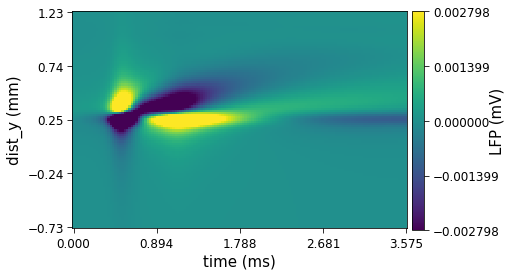

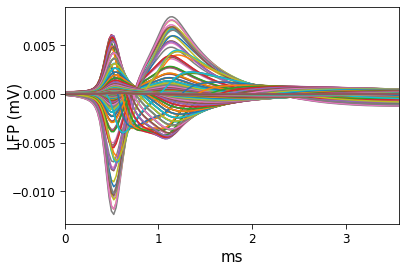

In [40]:
ix = 1
x_dist = np.unique(coords[:,0])
e_idx = coords[:,0]==x_dist[ix]

_ = plot_lfp_heatmap(t, coords[e_idx, 1], windowed_lfp[cell_idx][:, e_idx], vlim='auto',
                        fontsize=15, labelpad=-10, ticksize=12, tick_length=5, nbins=5)

_ = plot_lfp_traces(t, windowed_lfp[cell_idx], fontsize=15, labelpad=-10, ticksize=12, tick_length=5, nbins=5)